# IEEE VGG16 Cats and Dog Classifier
This project is sponsored by UW Madison Student Chapter of IEEE. This project is a seminar code for the IEEE - Intro to Machine Learning event. The goal of this project is to leverage a established machine learning model to classify simple images -- cats and dogs for this event. Through a hands-on experience, this abstract tutorial on machine learning seeks to inspire and improve familarity with machine learning and machine learning concepts.  

This project leverages the architecture of the VGG16 Model. The VGG16 is a 16 layer convultional deep network that was originally trained on ImageNet. We are using transfer learning to improve the power of the model. For deep learning, machine learning models learn patterns like edge detection which can be applied to other features. For this project, only the architecture and core pre-trained weights will be used. The final dense layer will be trained on the Kaggle Cats and Dogs Dataset

## Code Components
- Data Preperation 
- Model Setup
- Model Training
- Model Utilization


### Dependencies

In [1]:
import numpy as np #NECESSARY FOR ARRAY PREPERATION AND MACHINE LEARNING
from matplotlib import pyplot as plt #WE ARE USING MATPLOTLIB TO PLOT OUR WORK AS WE DEVELOP
from sklearn.metrics import confusion_matrix #THIS IS USED IN THE END TO SEE VISUALLY THE ACCURACY OF OUR MODEL
import itertools #THIS IS NECESSARY FOR THE CONFUSION MATRIX FUNCTION 
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam 
from keras.metrics import categorical_crossentropy 

from keras.preprocessing.image import ImageDataGenerator 
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import * 

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
#This is a confustion matrix that helps visualize the data
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#Visualize the Dataset from the datagen
FIG_SIZE = (12,6)
ROWS = 2
def plots(ims, figsize=FIG_SIZE, rows=ROWS, interp=False, titles=None, class_map = None):
    """
    Modified
    Source: https://github.com/smileservices/keras_utils/blob/master/utils.py
    """
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            title = titles[i]
            l = title.astype("int8").tolist()
            if class_map is not None:
                title = class_map[l.index(1)]
            sp.set_title(title, fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

### Data Preparation


In [4]:
TARGET_SIZE = (224,224)  #Height x Width
CLASSES = ["Cat", "Dog"] #Represents the Image Classes
BATCH_SIZE = 10          #The number of Photo in the Directory
DATA_PATH = './data'
VAL_SPLIT = .3
RESCALE = 1./255

In [5]:
datagen = ImageDataGenerator(validation_split=VAL_SPLIT, rescale=RESCALE)

train_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size = TARGET_SIZE,
    classes = CLASSES,
    batch_size = BATCH_SIZE,
    subset='training')

val_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size = TARGET_SIZE,
    classes = CLASSES,
    batch_size = BATCH_SIZE,
    subset='validation')

Found 17472 images belonging to 2 classes.
Found 7486 images belonging to 2 classes.


In [6]:
TEST_PATH = "./data/Testing"
test_gen = ImageDataGenerator().flow_from_directory(TEST_PATH, target_size = TARGET_SIZE, classes = CLASSES, batch_size = 10)

Found 42 images belonging to 2 classes.


C:\Users\Russel\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


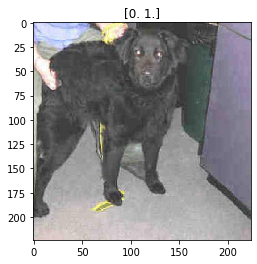

In [7]:
#Let us see a sample image 
test_imgs, test_labels = next(train_gen)
plt.title(test_labels[0])
plt.imshow(test_imgs[0])

### Model Creation

* Step 1: Import the original pre-trained VGG16 model
* Step 2: Remove the last layer of VGG16 model
* Step 3: Make sure to lock each layer of the model to be immutable during training
* Step 4: Add the dense layer for the number of classifications
* Step 5: Hypertune the parameters


In [8]:
#Step 1: Import the original VGG16 model
vgg16_model = keras.applications.vgg16.VGG16()

#Step 2: Pop the last layer
vgg16_model.layers.pop()

In [9]:
#Step 3: Create a new model and lock in layers
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False

In [10]:
#Step 4: Add the dense layer for classification
model.add(Dense(2, activation = 'softmax')) 

In [11]:
#Step 5: Hypertune parameters
LEARNING_RATE = .0001
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']

model.compile(Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

### Model Training 

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.90, verbose = 1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
callbacks=[es,mc]

In [14]:
history = model.fit_generator(train_gen, steps_per_epoch = 20, validation_data = val_gen, validation_steps = 5, epochs = 5, verbose =1, callbacks=[es, mc])

Epoch 1/5
20/20 [==============================] - 7s 373ms/step - loss: 0.6685 - accuracy: 0.6450 - val_loss: 0.5835 - val_accuracy: 0.5800

Epoch 00001: saving model to best_model.h5
Epoch 2/5
20/20 [==============================] - 6s 293ms/step - loss: 0.6378 - accuracy: 0.6500 - val_loss: 0.6523 - val_accuracy: 0.5600

Epoch 00002: saving model to best_model.h5
Epoch 3/5
20/20 [==============================] - 6s 305ms/step - loss: 0.5906 - accuracy: 0.7000 - val_loss: 0.5501 - val_accuracy: 0.7800

Epoch 00003: saving model to best_model.h5


C:\Users\Russel\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Russel\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Russel\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Russel\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Russel\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting

Epoch 4/5
20/20 [==============================] - 6s 304ms/step - loss: 0.5799 - accuracy: 0.7400 - val_loss: 0.5701 - val_accuracy: 0.5800

Epoch 00004: saving model to best_model.h5
Epoch 5/5
20/20 [==============================] - 6s 295ms/step - loss: 0.6019 - accuracy: 0.6950 - val_loss: 0.6266 - val_accuracy: 0.8600

Epoch 00005: saving model to best_model.h5


In [15]:
#Manually Saving and Deleting the model weights
#model.save('9-5-2020.h5')
#del model
#model = Sequential()
#for layer in vgg16_model.layers:
#    model.add(layer)
#for layer in model.layers:
#    layer.trainable = False
#model.add(Dense(2, activation = 'softmax')) 
#model = model.load_weights('9-5-2020.h5')

### Model Testing

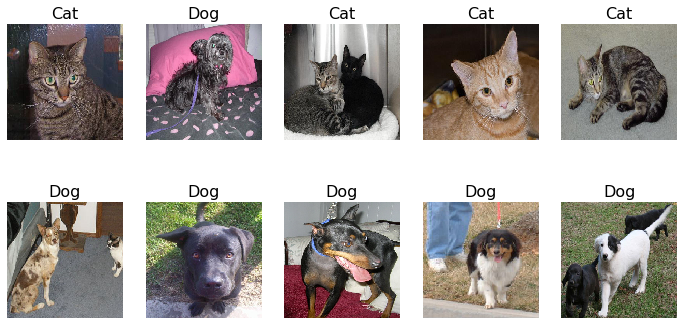

In [16]:
test_imgs, test_labels = next(test_gen)
plots(test_imgs, titles = test_labels, class_map = CLASSES) 
#Single Image Identification
#x = test_imgs[0]
#dat= []
#dat.append(x)
#dat = np.array(dat)
#model.predict(dat)
#plt.imshow(test_imgs[0])

In [17]:
STEPS = 5 #Number of Items to yield to the generator
predictions = model.predict_generator(test_gen, steps = STEPS, verbose=0) #MAKE SURE THIS GENERATOR CREATES SUFFICIENT IMAGES

In [18]:
#WE CONVERT THE TEST_LABELS INTO ITS CATEGORIES
test_labels = test_gen.classes 
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[ 7 14]
 [ 9 12]]


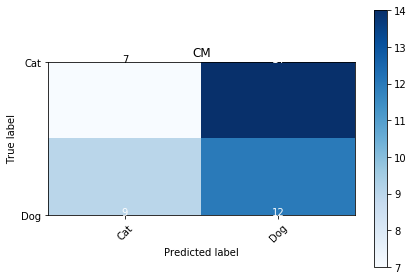

In [19]:
cm_plot_labels = CLASSES
plot_confusion_matrix(cm, cm_plot_labels, title='CM')

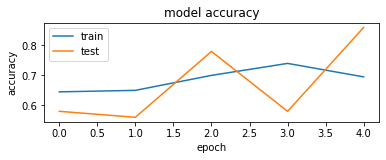

In [20]:
#THIS MODEL WAS SOURCED FROM THE INTERNET. THIS GRAPH SIMPLY TRACKS THE MODEL'S ACCURACY HISTORY
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

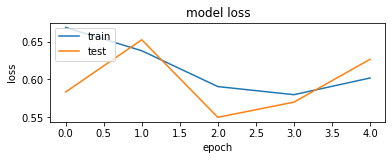

In [21]:
#THIS MODEL WAS SOURCED FROM THE INTERNET. THIS GRAPH SIMPLY TRACKS THE MODEL'S LOSS HISTORY
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')